In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from joblib import dump, load

In [2]:
DATA_PATH = '../data/BipolarDerivedDataTraining.csv'
NTHREADS = 32

In [3]:
bp_df = pd.read_csv(DATA_PATH)

In [4]:
bp_df.head()

,record_id,group,age,gender,handedness,ses_ladder_rung,history_smoking,frequency_currentsmoking,age_at_first_mood_syndrome,madrs_score,...,31p_cc_ant_gatp,31p_cc_ant_gatpr,31p_cc_ant_aatp,31p_cc_ant_aatpr,31p_l_pat_ph,31p_l_pat_pcr,31p_l_pat_gatp,31p_l_pat_gatpr,31p_l_pat_aatp,31p_l_pat_aatpr
0,1035,Case,29,Female,Right,2,Past Smoker,Not at all,14.0,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1637,Case,52,Female,Right,3,NaN,NaN,6.0,23,...,5918480.0,0.630314,8678260.0,0.790509,7.24003,10736800.0,3556370.0,0.490448,3544560.0,0.448918
2,1462,Case,51,Female,Right,4,Never Smoker,Not at all,33.0,28,...,8242230.0,0.921422,3362510.0,0.445127,7.16535,11783200.0,6115790.0,0.580259,4545140.0,0.530136
3,1264,Case,57,Female,Right,4,Never Smoker,Not at all,16.0,13,...,9900240.0,0.720967,3497420.0,0.562180,7.23599,8189780.0,5744920.0,0.705318,3075420.0,0.444548
4,1263,Case,41,Female,Right,9,Current Smoker,Some days,11.0,28,...,13869000.0,0.529107,6048170.0,0.260253,7.30881,16719200.0,11416500.0,0.638139,3904680.0,0.247752


In [5]:
# select the t1r columns
t1r_df = bp_df.filter(regex=("t1r_.*m"))
display(t1r_df.shape)
t1r_df.head()

(88, 280)

,t1r_l_latvent_m,t1r_l_inflatvent_m,t1r_l_cbmwm_m,t1r_l_cbmwm_nv,t1r_l_cbmctx_m,t1r_l_cbmctx_nv,t1r_l_thalproper_m,t1r_l_caud_m,t1r_l_putam_m,t1r_l_putam_nv,...,t1r_wmrins_nv,t1r_lg_occip_sup_m,t1r_lg_subcallosal_m,t1r_rg_occip_sup_m,t1r_rg_subcallosal_m,t1r_l_unsegmentedwm_m,t1r_l_unsegmentedwm_nv,t1r_r_unsegmentedwm_m,t1r_r_unsegmentedwm_nv,t1r_venousblood_m
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,158.093,335.357,76.665300,14655.0,77.283500,51754.0,100.9360,86.6070,94.771900,3577.0,...,20948.0,100.5010,48.2335,109.553,59.8377,95.05630,724.0,84.45810,1736.0,61.0105
2,151.567,120.507,88.953800,13294.0,100.712000,52096.0,81.5130,66.9743,72.100400,4875.0,...,23262.0,85.4466,53.4756,105.163,43.6359,74.90810,738.0,77.38230,2110.0,80.5913
3,116.295,0.000,0.132391,11416.0,0.531013,44469.0,27.4315,20.9656,-0.000544,3748.0,...,19722.0,126.1400,0.0000,109.258,0.0000,1.72019,703.0,-3.94339,1871.0,63.9332
4,137.606,135.274,78.784100,10825.0,91.652200,44206.0,85.7070,72.9229,72.839800,4587.0,...,21677.0,109.7430,86.4271,97.500,72.0180,77.17380,649.0,82.15930,1893.0,95.7019


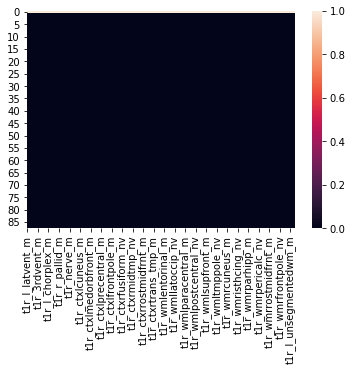

In [6]:
# looks like only the first record has missing data
sns.heatmap(t1r_df.isna())

In [7]:
# Are there any nans beyond the first row?
t1r_df.loc[1:,:].isna().values.any()

False

In [8]:
# since the first row is all nans, we will drop that row
t1r_df.drop(0, axis=0, inplace=True)
t1r_df.head()

/home/zoheb/anaconda3/envs/comfy_pants/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,t1r_l_latvent_m,t1r_l_inflatvent_m,t1r_l_cbmwm_m,t1r_l_cbmwm_nv,t1r_l_cbmctx_m,t1r_l_cbmctx_nv,t1r_l_thalproper_m,t1r_l_caud_m,t1r_l_putam_m,t1r_l_putam_nv,...,t1r_wmrins_nv,t1r_lg_occip_sup_m,t1r_lg_subcallosal_m,t1r_rg_occip_sup_m,t1r_rg_subcallosal_m,t1r_l_unsegmentedwm_m,t1r_l_unsegmentedwm_nv,t1r_r_unsegmentedwm_m,t1r_r_unsegmentedwm_nv,t1r_venousblood_m
1,158.093,335.357,76.665300,14655.0,77.283500,51754.0,100.9360,86.6070,94.771900,3577.0,...,20948.0,100.5010,48.2335,109.553,59.8377,95.05630,724.0,84.45810,1736.0,61.0105
2,151.567,120.507,88.953800,13294.0,100.712000,52096.0,81.5130,66.9743,72.100400,4875.0,...,23262.0,85.4466,53.4756,105.163,43.6359,74.90810,738.0,77.38230,2110.0,80.5913
3,116.295,0.000,0.132391,11416.0,0.531013,44469.0,27.4315,20.9656,-0.000544,3748.0,...,19722.0,126.1400,0.0000,109.258,0.0000,1.72019,703.0,-3.94339,1871.0,63.9332
4,137.606,135.274,78.784100,10825.0,91.652200,44206.0,85.7070,72.9229,72.839800,4587.0,...,21677.0,109.7430,86.4271,97.500,72.0180,77.17380,649.0,82.15930,1893.0,95.7019
5,212.272,294.991,96.990900,13410.0,110.286000,48703.0,107.4960,90.0523,81.547100,3915.0,...,21800.0,128.2830,11.1350,126.765,12.8967,85.63990,586.0,89.07550,1860.0,69.7897


In [9]:
# define the group classification
group = bp_df.loc[1:,'group']

In [10]:
group

1        Case
2        Case
3        Case
4        Case
5        Case
6        Case
7        Case
8        Case
9        Case
10       Case
11       Case
12       Case
13       Case
14       Case
15       Case
16       Case
17       Case
18       Case
19       Case
20       Case
21       Case
22       Case
23       Case
24       Case
25       Case
26       Case
27       Case
28       Case
29       Case
30       Case
       ...   
58    Control
59    Control
60    Control
61    Control
62    Control
63    Control
64    Control
65    Control
66    Control
67    Control
68    Control
69    Control
70    Control
71    Control
72    Control
73    Control
74    Control
75    Control
76    Control
77    Control
78    Control
79    Control
80    Control
81    Control
82    Control
83    Control
84    Control
85    Control
86    Control
87    Control
Name: group, Length: 87, dtype: object

In [11]:
# split the data into test/training sets (test size will have 10 participants)
X_train, X_test, y_train, y_test = train_test_split(t1r_df, group, test_size=10, stratify=group)

In [12]:
# look at the training dataset
X_train.head()

,t1r_l_latvent_m,t1r_l_inflatvent_m,t1r_l_cbmwm_m,t1r_l_cbmwm_nv,t1r_l_cbmctx_m,t1r_l_cbmctx_nv,t1r_l_thalproper_m,t1r_l_caud_m,t1r_l_putam_m,t1r_l_putam_nv,...,t1r_wmrins_nv,t1r_lg_occip_sup_m,t1r_lg_subcallosal_m,t1r_rg_occip_sup_m,t1r_rg_subcallosal_m,t1r_l_unsegmentedwm_m,t1r_l_unsegmentedwm_nv,t1r_r_unsegmentedwm_m,t1r_r_unsegmentedwm_nv,t1r_venousblood_m
37,114.190,141.342,105.9060,12735.0,94.0150,49520.0,79.6931,76.5813,76.8690,4130.0,...,23256.0,93.0578,86.0943,106.3600,56.6147,77.5196,730.0,81.8175,2044.0,81.4910
80,110.599,123.483,90.4807,11987.0,91.1944,46998.0,82.9245,67.0857,69.4067,4585.0,...,20864.0,84.5783,62.4651,81.0018,29.5964,76.2032,700.0,80.0251,1917.0,110.5090
44,190.236,190.647,39.4630,14321.0,79.2859,51007.0,92.4465,89.9835,80.9080,5419.0,...,24293.0,119.0050,103.1170,116.1430,83.0610,90.7402,711.0,88.6365,2258.0,58.0664
71,110.077,131.100,88.7175,13103.0,90.9913,45814.0,79.0933,78.7152,73.2910,4549.0,...,21001.0,63.2213,102.6330,92.1250,33.2038,79.7179,700.0,76.5876,1768.0,75.5213
6,129.442,175.494,85.6282,12130.0,90.8607,49979.0,86.1446,97.2222,75.5715,4437.0,...,22327.0,125.7770,57.1883,112.3460,107.5530,83.1909,713.0,91.0801,2162.0,43.1079


In [13]:
# look at the testing data
X_test.head()

,t1r_l_latvent_m,t1r_l_inflatvent_m,t1r_l_cbmwm_m,t1r_l_cbmwm_nv,t1r_l_cbmctx_m,t1r_l_cbmctx_nv,t1r_l_thalproper_m,t1r_l_caud_m,t1r_l_putam_m,t1r_l_putam_nv,...,t1r_wmrins_nv,t1r_lg_occip_sup_m,t1r_lg_subcallosal_m,t1r_rg_occip_sup_m,t1r_rg_subcallosal_m,t1r_l_unsegmentedwm_m,t1r_l_unsegmentedwm_nv,t1r_r_unsegmentedwm_m,t1r_r_unsegmentedwm_nv,t1r_venousblood_m
9,182.152,148.437,94.8717,10659.0,118.5230,41462.0,92.2300,68.4237,82.9205,3856.0,...,17064.0,94.7922,18.5376,124.0740,41.91270,84.1607,613.0,83.1743,1622.0,74.5044
64,271.395,114.346,95.0231,12617.0,63.3463,45470.0,129.0580,163.8050,93.4602,4104.0,...,22147.0,84.9078,31.0921,85.9344,57.51050,113.0210,716.0,141.1520,2063.0,67.8469
85,185.549,-242.450,48.3554,13751.0,62.6234,49749.0,94.3950,79.6193,81.0971,4937.0,...,23613.0,90.8113,94.4127,86.7077,76.02760,95.6378,828.0,82.6605,2238.0,75.0577
47,191.810,160.262,107.5560,15035.0,99.3148,57157.0,92.3275,86.9967,80.8572,4773.0,...,21056.0,67.1048,-18.4892,85.0746,2.47692,94.7498,719.0,104.6230,1904.0,91.8825
70,152.917,163.997,79.3317,14253.0,91.9592,60508.0,81.2640,69.7683,72.7048,4615.0,...,21733.0,105.3630,56.6466,99.1019,52.81490,71.7243,769.0,78.4956,2201.0,52.6758


In [14]:
# see how many are Case/Controls in the training dataset
y_train.describe()

count       77
unique       2
top       Case
freq        50
Name: group, dtype: object

In [15]:
# see how many are Case/Controls are in the testing dataset
y_test.describe()

count       10
unique       2
top       Case
freq         6
Name: group, dtype: object

In [16]:
# test pca
pca_test = PCA(n_components=0.99)


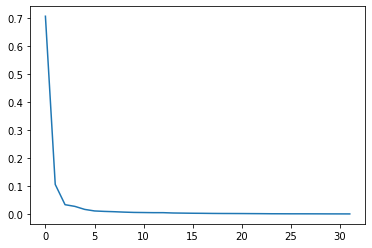

In [17]:
# the first component explains a lot of the variance, but up to 4 could be included
pca_test.fit_transform(X_train)
plt.plot(pca_test.explained_variance_ratio_)

In [18]:
# lets try logistic regression on the raw data
alllowercase = xgb.XGBClassifier(n_jobs=NTHREADS)


In [19]:
alllowercase.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=32, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [20]:
alllowercase.score(X_test, y_test)

0.5

In [21]:
# test to see how different parameters change the fit of the model


In [22]:
alllowercase.predict(X_test)

array(['Case', 'Case', 'Case', 'Control', 'Case', 'Case', 'Case',
       'Control', 'Control', 'Case'], dtype=object)

In [23]:
y_test.values

array(['Case', 'Control', 'Control', 'Case', 'Control', 'Case', 'Case',
       'Case', 'Control', 'Case'], dtype=object)

In [24]:
# normalization of data
scaler = StandardScaler()

# setup a pipeline to run PCA, then run Logistic Regression

# setup PCA
pca = PCA()
# define the options I would like to vary within PCA
n_components_opts = [2] # , 4, 8]
whiten_opts = [False] #, True]


# define my classifier (xgb)
clf = xgb.XGBClassifier(max_iter=1000)

learningrateopts = [0.1] # , 0.01, 0.001, .0001]
max_depthopts = [6, 60, 600, 6000]
scale_pos_weightopts = [0, 1, 5]


# place the parameters I would like to vary using a list of dictionaries
grid_params = [
    {
        'pca__n_components': n_components_opts,
        'pca__whiten': whiten_opts,
        'clf__learning_rate': learningrateopts,
        'clf__max_depth': max_depthopts,
    }
]


pipeline = Pipeline([("scaler", scaler), ("pca", pca), ("clf", clf)])

In [25]:
# search the parameter defined above to find the "best" model
search = GridSearchCV(pipeline, n_jobs=NTHREADS, param_grid=grid_params, cv=10, scoring='roc_auc')

In [26]:
# fit on the training data
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
            

In [27]:
# see the parameters for the best model
search.best_params_

{'clf__learning_rate': 0.1,
 'clf__max_depth': 60,
 'pca__n_components': 2,
 'pca__whiten': False}

In [28]:
# get the score for the held out test data
search.score(X_test, y_test)

0.29166666666666663

In [29]:
# see how well the algorithm guessed on the held out testing data
search.predict(X_test) == y_test.values

array([ True, False, False,  True, False, False, False,  True, False,
       False])

In [30]:
search.predict(X_test)

array(['Case', 'Case', 'Case', 'Case', 'Case', 'Control', 'Control',
       'Case', 'Case', 'Control'], dtype=object)

In [31]:
y_test.values

array(['Case', 'Control', 'Control', 'Case', 'Control', 'Case', 'Case',
       'Case', 'Control', 'Case'], dtype=object)

In [32]:
fittimetestscore = pd.DataFrame(search.cv_results_)
fittimetestscore

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__max_depth,param_pca__n_components,param_pca__whiten,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.282030,0.111721,0.029647,0.026042,0.1,6,2,False,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.733333,...,0.600000,1.0,0.600000,0.866667,1.0,0.55,0.75,0.746667,0.166633,4
1,0.383437,0.085911,0.018372,0.011045,0.1,60,2,False,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.666667,...,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75,0.760000,0.156738,1
2,0.356798,0.067414,0.029437,0.025577,0.1,600,2,False,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.666667,...,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75,0.760000,0.156738,1
3,0.152165,0.084086,0.029154,0.017064,0.1,6000,2,False,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.666667,...,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75,0.760000,0.156738,1


In [33]:
testscore = fittimetestscore.filter(regex=("split.*"))
testscore

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score
0,0.733333,0.833333,0.533333,0.600000,1.0,0.600000,0.866667,1.0,0.55,0.75
1,0.666667,0.833333,0.533333,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75
2,0.666667,0.833333,0.533333,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75
3,0.666667,0.833333,0.533333,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75


In [34]:
split0 = fittimetestscore.loc[fittimetestscore.loc[:, 'split0_test_score'] >0.5, :]
split1 = split0.loc[split0.loc[:, 'split1_test_score'] >0.5, :]
split2 = split1.loc[split1.loc[:, 'split2_test_score'] >0.5, :]
split3 = split2.loc[split2.loc[:, 'split3_test_score'] >0.5, :]
split4 = split3.loc[split3.loc[:, 'split4_test_score'] >0.5, :]
split5 = split4.loc[split4.loc[:, 'split5_test_score'] >0.5, :]
split6 = split5.loc[split5.loc[:, 'split6_test_score'] >0.5, :]

In [35]:
split6

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__max_depth,param_pca__n_components,param_pca__whiten,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.282030,0.111721,0.029647,0.026042,0.1,6,2,False,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.733333,...,0.600000,1.0,0.600000,0.866667,1.0,0.55,0.75,0.746667,0.166633,4
1,0.383437,0.085911,0.018372,0.011045,0.1,60,2,False,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.666667,...,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75,0.760000,0.156738,1
2,0.356798,0.067414,0.029437,0.025577,0.1,600,2,False,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.666667,...,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75,0.760000,0.156738,1
3,0.152165,0.084086,0.029154,0.017064,0.1,6000,2,False,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.666667,...,0.666667,1.0,0.733333,0.866667,1.0,0.55,0.75,0.760000,0.156738,1


In [36]:
search.best_params_

{'clf__learning_rate': 0.1,
 'clf__max_depth': 60,
 'pca__n_components': 2,
 'pca__whiten': False}

In [43]:
# export model

import pickle

with open('../models/kerry-pipeline1_prediction.pkl', 'wb') as f:
    pickle.dump(search, f)